In [1]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [60]:
(X_train, _), (X_test, _) = mnist.load_data()
all_data = np.concatenate((X_train, X_test))
all_data.shape

(70000, 28, 28)

In [61]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Reshape
keras.backend.clear_session()

In [62]:
#Custom layers for efficiency
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name='bias',
                                      shape=[self.dense.input_shape[-1]],
                                      initializer='zeros')
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [63]:
inputs = keras.Input(shape=(28,28,1))
dense_1 = Dense(784, activation='selu')
dense_2 = Dense(392, activation='selu')
dense_3 = Dense(196, activation='selu')

x = Flatten()(inputs)

#Encoder
x = dense_1(x)
x = dense_2(x)
x = dense_3(x)
x = DenseTranspose(dense_3, activation='selu')(x)
x = DenseTranspose(dense_2, activation='selu')(x)
x = DenseTranspose(dense_1, activation='sigmoid')(x)

outputs = Reshape([28,28])(x)

tied_ae = keras.Model(inputs=inputs, outputs=outputs)
tied_ae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 784)               615440    
_________________________________________________________________
dense_1 (Dense)              (None, 392)               307720    
_________________________________________________________________
dense_2 (Dense)              (None, 196)               77028     
_________________________________________________________________
dense_transpose (DenseTransp (None, 392)               77420     
_________________________________________________________________
dense_transpose_1 (DenseTran (None, 784)               308504

In [64]:
X_train      = X_train.astype('float32') / 255
X_test       = X_test.astype('float32') / 255
X_train_norm = np.reshape(X_train, (60000,28,28,1))
X_test_norm  = np.reshape(X_test,  (10000,28,28,1))

In [65]:
tied_ae.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
hist = tied_ae.fit(X_train_norm, X_train_norm, epochs=10, validation_data=[X_test_norm, X_test_norm])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 23s 380us/sample - loss: 0.0082 - accuracy: 0.2973 - val_loss: 0.0037 - val_accuracy: 0.3213
Epoch 2/10
60000/60000 [==============================] - 22s 363us/sample - loss: 0.0035 - accuracy: 0.3346 - val_loss: 0.0033 - val_accuracy: 0.3297
Epoch 3/10
60000/60000 [==============================] - 23s 380us/sample - loss: 0.0032 - accuracy: 0.3404 - val_loss: 0.0030 - val_accuracy: 0.3313
Epoch 4/10
60000/60000 [==============================] - 23s 381us/sample - loss: 0.0031 - accuracy: 0.3434 - val_loss: 0.0029 - val_accuracy: 0.3367
Epoch 5/10
60000/60000 [==============================] - 24s 393us/sample - loss: 0.0029 - accuracy: 0.3462 - val_loss: 0.0030 - val_accuracy: 0.3407
Epoch 6/10
60000/60000 [==============================] - 26s 438us/sample - loss: 0.0029 - accuracy: 0.3475 - val_loss: 0.0028 - val_accuracy: 0.3455
Epoch 7/10
60000/60000 [====================

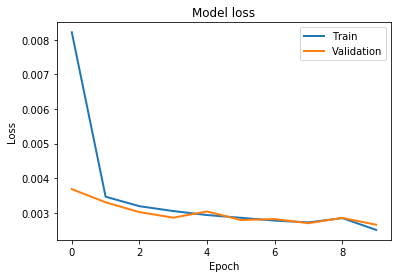

In [66]:
plt.plot(hist.history['loss'], linewidth=2, label='Train')
plt.plot(hist.history['val_loss'], linewidth=2, label='Validation')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [67]:
# Encode and decode some digits
decoded_imgs = tied_ae.predict(X_test_norm)

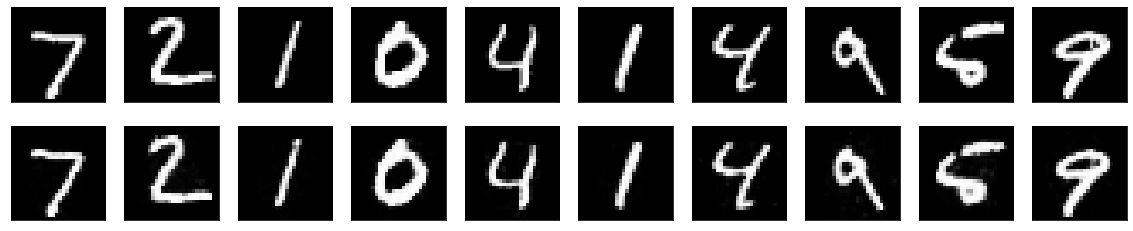

In [68]:
n=10
plt.figure(figsize=(20,4))

for i in range(n):
    ax = plt.subplot(2,n,i+1)
    plt.imshow(x_test_norm[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()